#INTRODUCTION 

**Caveat** : Running this notebook will take a while if you do decide to fork so take note. A handful of minutes.

This notebook will aim to provide an explanation and application of different feature ranking methods, namely that of Recursive Feature Elimination (RFE), Stability Selection, linear models as well as Random Forest. But first off, it is always imperative to give credit where credit is due. The stuff in this notebook is indebted to and borrows heavily from the excellent 4-part blog article by Ando Saabas on feature selection. So please do check out his article from this link: http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/ 

The contents of this notebook are as follows: 

 1. **Data Cleaning and Visualisation** : This section will revolve around exploring the data and visualising some summary statistics. 
 2. **Stability Selection via Randomised Lasso Method** : Introduce a relatively new feature selection method called "Stability Selection" and using the Randomised Lasso in its implementation
 3. **Recursive Feature Elimination** : Implementing the Recursive Feature Elimination method of feature ranking via the use of basic Linear Regression 
 4. **Linear Model Feature Coefficients** : Implementing 3 of Sklearn's linear models (Linear Regression, Lasso and Ridge) and using the inbuilt estimated coefficients for our feature selection
 5. **Random Forest Feature Selection** : Using the Random Forest's convenient attribute "feature_importances" to calculate and ultimately rank the feature importance.

Finally, with all the points 1 to 5 above, we will combine the results to create our:

**Feature Ranking Matrix** : Matrix of all the features along with the respective model scores which we can use in our ranking.
 

**RFE** 

if n(feature to build model) to 1 then backward elimination
if 1 to n then forward elimination

**Recursive feature reduction**

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.



In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# 1. DATA CLEANSING AND ANALYSIS

Let's first read in the house data as a dataframe "house" and inspect the first 5 rows

In [62]:
house = pd.read_csv("/home/rohan/Desktop/jupyter/ROHAN_ALL/SM_&_ML/Datasets/kc_house_data.csv")
house.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639


Now its time for some general data inspection. Let's first examine to see if there are any nulls in the dataframe as well as look at the type of the data (i.e whether it is a string or numeric)

In [63]:
# Looking for nulls
x = pd.DataFrame(house.isnull().sum())
x.T

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Inspecting type
print(house.dtypes.value_counts())

int64      15
float64     5
object      1
dtype: int64


The data is pretty clean. There are no pesky nulls which we need to treat and most of the features are in numeric format. Let's go ahead and drop the "id" and "date" columns as these 2 features will not be used in this analysis.

In [64]:
# Dropping the id and date columns
house = house.drop(['id', 'date'],axis=1)

**Pairplot Visualisation**

Let's create some Seaborn pairplots for the features ('sqft_lot','sqft_above','price','sqft_living','bedrooms') to get a feel for how the various features are distributed vis-a-vis the price as well as the number of bedrooms

In [193]:
#sns.pairplot(house[['sqft_lot','sqft_above','price','sqft_living','bedrooms']], hue='bedrooms', palette='afmhot',size=1.4)

In [194]:
# with sns.plotting_context("notebook",font_scale=2.5):
#     g = sns.pairplot(house[['sqft_lot','sqft_above','price','sqft_living','bedrooms']], 
#                  hue='bedrooms', palette='tab20',size=6)
# g.set(xticklabels=[]);

From the pairplots, we seem to get the classical linear distribution of the data points, for example with price against sqft_living. This bodes well as in the latter analysis, we will implement some linear models which we will use in our Feature ranking. Let's look at the correlation heatmap: 

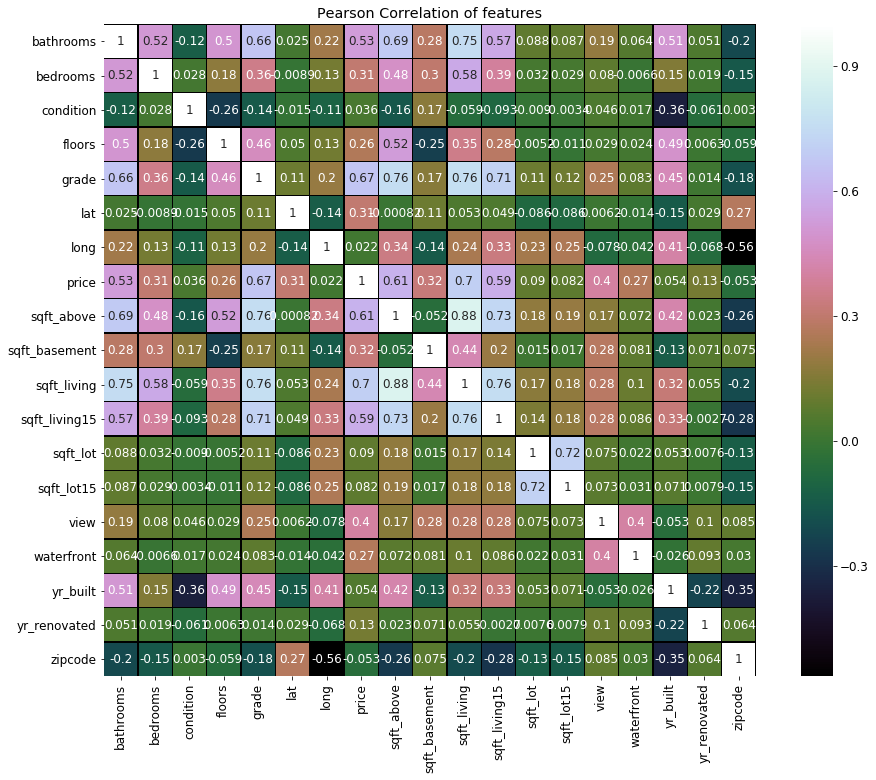

In [65]:
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in house.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = house.columns.difference(str_list) 
# Create Dataframe containing only numerical features
house_num = house[num_list]
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation of features')
# Draw the heatmap using seaborn
#sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="PuBuGn", linecolor='k', annot=True)
sns.heatmap(house_num.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, cmap="cubehelix", linecolor='k', annot=True)

# 2. Stability Selection via Randomized Lasso

In a nutshell, this method serves to apply the feature selection on different parts of the data and features repeatedly until the results can be aggregated. Therefore stronger features ( defined as being selected as important) will have greater scores in this method as compared to weaker features. Refer to this paper by Nicolai Meinshausen and Peter Buhlmann for a much greater detail on the method : http://stat.ethz.ch/~nicolai/stability.pdf

In this notebook, the Stability Selection method is conveniently inbuilt into sklearn's randomized lasso model and therefore this will be implemented as follows:

In [66]:
# First extract the target variable which is our House prices
Y = house.price.values
# Drop price from the house dataframe and create a matrix out of the house data
#house = house.drop(['price'], axis=1)
X = house.as_matrix()
# Store the column/feature names into a list "colnames"
colnames = house.columns

/home/rohan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


#### **ranking** -  function to standardize the values(variable_ranking) & then club them with the column_name


#### Variable ranking can be :
    1. coefficient of linear regressor,lasso regressor,ridge regressor model
    2. variable importance of a Random forest model
    3. variable_ranking of a RFE model which can take any of ML method as estimator


In [67]:
house.shape

(21613, 18)

In [68]:
X

array([[ 3.00000e+00,  1.00000e+00,  1.18000e+03, ..., -1.22257e+02,
         1.34000e+03,  5.65000e+03],
       [ 3.00000e+00,  2.25000e+00,  2.57000e+03, ..., -1.22319e+02,
         1.69000e+03,  7.63900e+03],
       [ 2.00000e+00,  1.00000e+00,  7.70000e+02, ..., -1.22233e+02,
         2.72000e+03,  8.06200e+03],
       ...,
       [ 2.00000e+00,  7.50000e-01,  1.02000e+03, ..., -1.22299e+02,
         1.02000e+03,  2.00700e+03],
       [ 3.00000e+00,  2.50000e+00,  1.60000e+03, ..., -1.22069e+02,
         1.41000e+03,  1.28700e+03],
       [ 2.00000e+00,  7.50000e-01,  1.02000e+03, ..., -1.22299e+02,
         1.02000e+03,  1.35700e+03]])

Next, we create a function which will be able to conveniently store our feature rankings obtained from the various methods described here into a Python dictionary. In case you are thinking I created this function, no this is not the case. All credit goes to Ando Saabas and I am only trying to apply what he has discussed in the context of this dataset.

In [69]:
# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [70]:
# Finally let's run our Selection Stability method with Randomized Lasso
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), colnames)
print('finished')

/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedLasso is deprecated; The class RandomizedLasso is deprecated in 0.19 and will be removed in 0.21.
  warnings.warn(msg, category=DeprecationWarning)
/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Memory is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Parallel is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/home/rohan/anaconda3/lib/python3.6/site-

/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  w

/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  w

/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  w

/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  w

/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  w

finished


/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  warnings.warn(msg, category=DeprecationWarning)
/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function delayed is deprecated; deprecated in version 0.20.1 to be removed in version 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib.
  w

In [71]:
pd.DataFrame(ranks).T

,bathrooms,bedrooms,condition,floors,grade,lat,long,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated,zipcode
rlasso/Stability,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.82,0.0,0.58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# 3. Recursive Feature Elimination ( RFE )

Now onto the next method in our feature ranking endeavour. Recursive Feature Elimination or RFE uses a model ( eg. linear Regression or SVM) to select either the best or worst-performing feature, and then excludes this feature. The whole process is then iterated until all features in the dataset are used up ( or up to a user-defined limit). Sklearn conveniently possesses a RFE function via the sklearn.feature_selection call and we will use this along with a simple linear regression model for our ranking search as follows:

#### Explaining how the ranking method is working & what are the arguments

- y corresponds to ranking assigned by rfe model(Lower Ranking better) then storing the result into 2d array(coz minmax() scale only works with 2d objects)


https://stackoverflow.com/questions/18243959/ranking-and-scores-in-recursive-feature-elimination-rfe-in-scikit-learn

In [72]:
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
rfe = RFE(lr, n_features_to_select=1, verbose =0 )
rfe.fit(X,Y)
#----------------
y = list(map(float, rfe.ranking_))
y_rank = np.array([y])
y_rank

array([[ 8.,  6., 12., 18., 10.,  1.,  5.,  7.,  3., 13., 14.,  9., 16.,
        11.,  2.,  4., 15., 17.]])

In [33]:
# scaling the ranks obtained(y_rank) var

# np.array([y]).T - makes y 2d and Transposes the result to get hstack
# (1*np.array([y]).T).T[0] - after standardization we get reusult in vstack form .T[0] again transposes it to hstack
sc = MinMaxScaler()
t =  sc.fit_transform(1*np.array([y]).T).T[0]
t = map(lambda x: round(x,2), t)

np.hstack(list(t))

array([0.41, 0.29, 0.65, 1.  , 0.53, 0.  , 0.24, 0.35, 0.12, 0.71, 0.76,
       0.47, 0.88, 0.59, 0.06, 0.18, 0.82, 0.94])

In [34]:
## Simply zip(colname:values) to the final result

ranking(list(map(float, rfe.ranking_)),colnames,order = 1)

{'bedrooms': 0.41,
 'bathrooms': 0.29,
 'sqft_living': 0.65,
 'sqft_lot': 1.0,
 'floors': 0.53,
 'waterfront': 0.0,
 'view': 0.24,
 'condition': 0.35,
 'grade': 0.12,
 'sqft_above': 0.71,
 'sqft_basement': 0.76,
 'yr_built': 0.47,
 'yr_renovated': 0.88,
 'zipcode': 0.59,
 'lat': 0.06,
 'long': 0.18,
 'sqft_living15': 0.82,
 'sqft_lot15': 0.94}

In [38]:
# from sklearn.feature_selection import RFECV


# rfecv = RFECV(estimator=lr,cv=5,step=1)
# rfecv.fit(X,Y)
# # s= ranking(list(map(float, rfecv.ranking_)), colnames, order=-1)
# rfecv.support_

#### -----------------------------------------------------------------

In [73]:
# Construct our Linear Regression model
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =0 )
rfe.fit(X,Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

# 4. Linear Model Feature Ranking

Now let's apply 3 different linear models (Linear, Lasso and Ridge Regression) and how the features are selected and prioritised via these models. To achieve this, I shall use the sklearn implementation of these models and in particular the attribute .coef to return the estimated coefficients for each feature in the linear model.

In [74]:
# Using Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(X,Y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

/home/rohan/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


# 5. Random Forest feature ranking

Sklearn's Random Forest model also comes with it's own inbuilt feature ranking attribute and one can conveniently just call it via "feature_importances_". That is what we will be using as follows:

#### ------------------------------------------- RFE with RF as estimator --------------------


- In this case the random forest builds 50 DT * 18 Iterations for 18 combinations of variables ending 1

#### -------------------------------------------------

In [75]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=0)
rf.fit(X,Y)
ranks["RF"] = ranking(rf.feature_importances_, colnames);

In [76]:
x = pd.DataFrame(ranks)
x

,rlasso/Stability,RFE,LinReg,Ridge,Lasso,RF
bathrooms,1.00,0.71,0.07,0.07,0.07,0.02
bedrooms,1.00,0.59,0.06,0.06,0.06,0.00
condition,1.00,0.65,0.04,0.04,0.04,0.00
floors,1.00,0.47,0.01,0.01,0.01,0.00
grade,1.00,0.88,0.16,0.16,0.16,1.00
lat,1.00,0.94,1.00,1.00,1.00,0.53
long,1.00,0.82,0.36,0.35,0.36,0.23
sqft_above,0.82,0.29,0.00,0.00,0.00,0.06
sqft_basement,0.00,0.24,0.00,0.00,0.00,0.01
sqft_living,0.58,0.35,0.00,0.00,0.00,0.93


# 6. Creating the Feature Ranking Matrix

We combine the scores from the various methods above and output it in a matrix form for convenient viewing as such:

In [49]:
# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")
 
print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	Lasso	LinReg	RF	RFE	Ridge	rlasso/Stability	Mean
bedrooms	0.06	0.06	0.0	0.41	0.06	1.0	0.26
bathrooms	0.07	0.07	0.02	0.29	0.07	1.0	0.25
sqft_living	0.0	0.0	0.95	0.65	0.0	0.45	0.34
sqft_lot	0.0	0.0	0.04	1.0	0.0	1.0	0.34
floors	0.01	0.01	0.0	0.53	0.01	1.0	0.26
waterfront	0.97	0.97	0.1	0.0	0.94	1.0	0.66
view	0.09	0.09	0.03	0.24	0.09	1.0	0.26
condition	0.04	0.04	0.0	0.35	0.04	1.0	0.25
grade	0.16	0.16	1.0	0.12	0.16	1.0	0.43
sqft_above	0.0	0.0	0.06	0.71	0.0	0.84	0.27
sqft_basement	0.0	0.0	0.01	0.76	0.0	0.0	0.13
yr_built	0.0	0.0	0.08	0.47	0.0	1.0	0.26
yr_renovated	0.0	0.0	0.0	0.88	0.0	1.0	0.31
zipcode	0.0	0.0	0.04	0.59	0.0	1.0	0.27
lat	1.0	1.0	0.53	0.06	1.0	1.0	0.77
long	0.36	0.36	0.22	0.18	0.35	1.0	0.41
sqft_living15	0.0	0.0	0.1	0.82	0.0	1.0	0.32
sqft_lot15	0.0	0.0	0.04	0.94	0.0	1.0	0.33


Now, with the matrix above, the numbers and layout does not seem very easy or pleasant to the eye. Therefore, let's just collate the mean ranking score attributed to each of the feature and plot that via Seaborn's factorplot.

In [50]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

In [51]:
rf.feature_importances_

array([0.00288614, 0.00705522, 0.28652544, 0.01390574, 0.00193492,
       0.03060022, 0.01228833, 0.00297574, 0.30227725, 0.01905674,
       0.00501588, 0.02455218, 0.0021507 , 0.01391001, 0.16235912,
       0.0685586 , 0.0305791 , 0.01336867])

In [52]:
import matplotlib.pyplot as plt 

/home/rohan/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/rohan/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


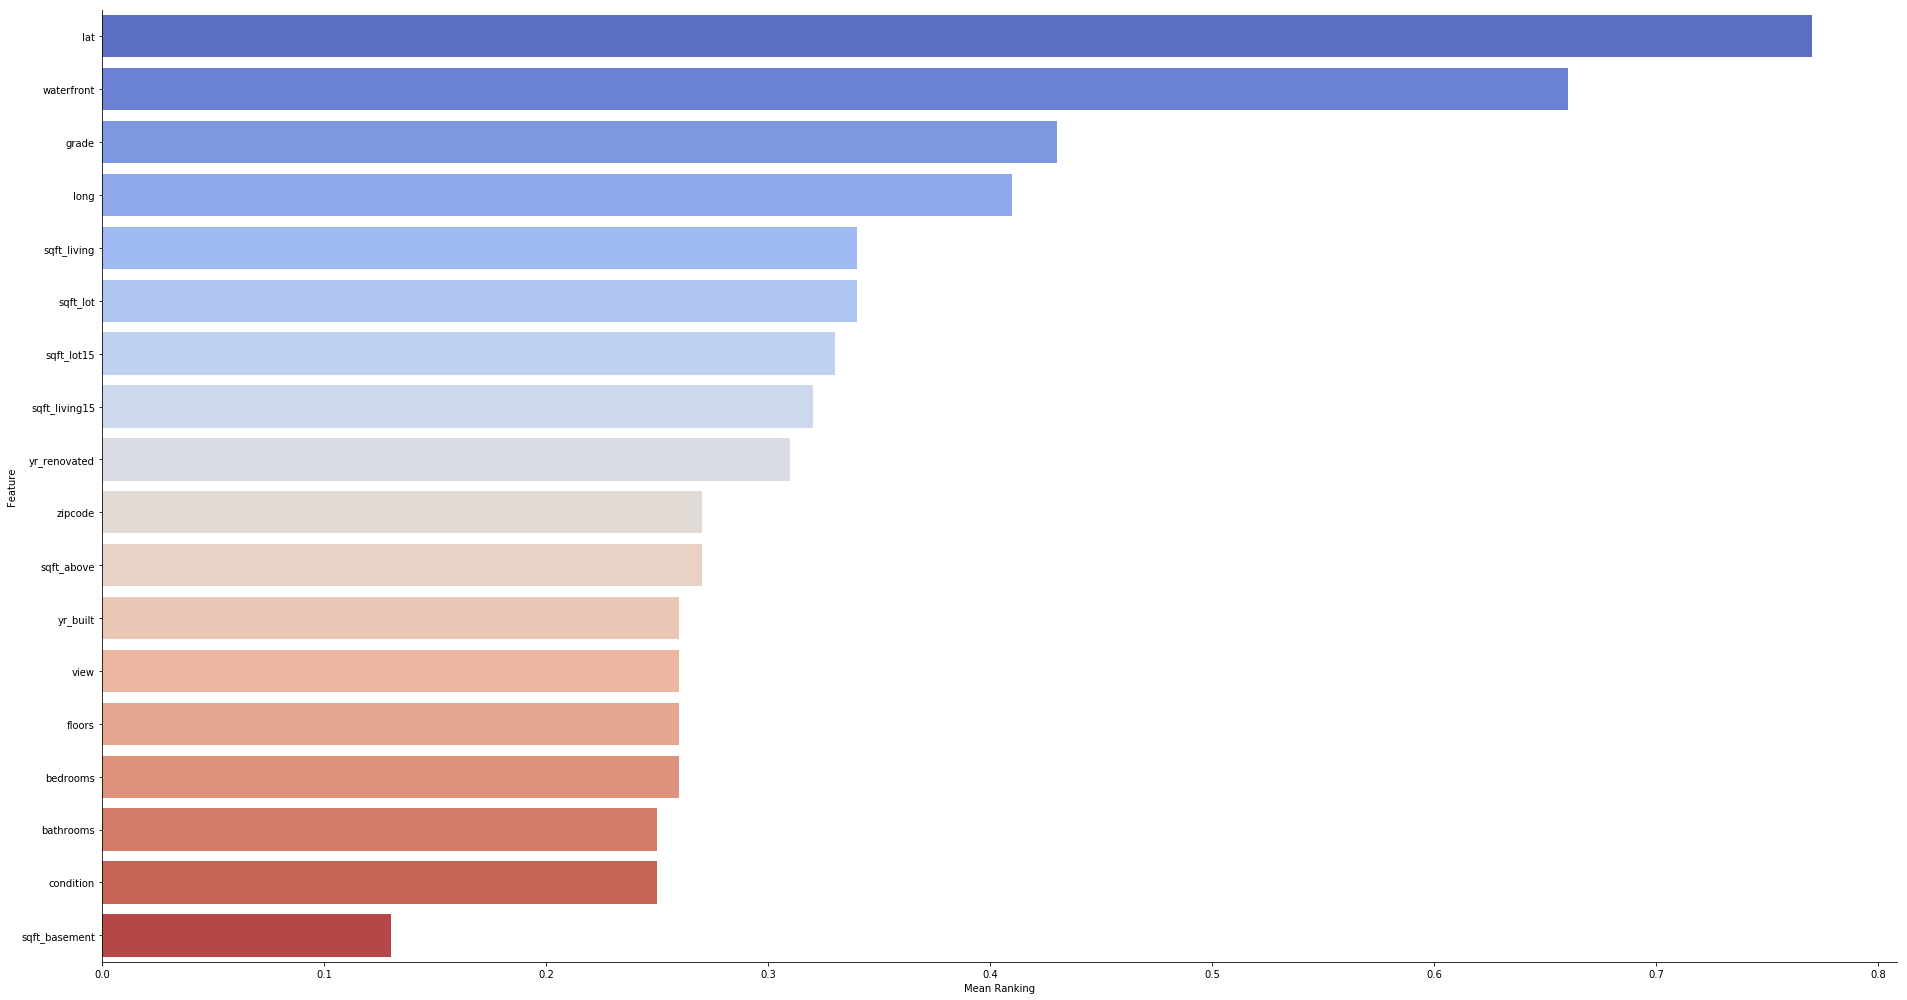

In [53]:
# Let's plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", 
               size=14, aspect=1.9, palette='coolwarm')


plt.rcParams.update({'font.size': 12})
# plt.text(fontdict={'font.size':12})

Well as you can see from our feature ranking endeavours, the top 3 features are 'lat', 'waterfront' and 'grade'. The bottom 3 are 'sqft_lot15', 'sqft_lot' and 'sqft_basement'. 
This sort of feature ranking can be really useful, especially if one has many many features in the dataset and would like to trim or cut off features that contribute negligibly.